# Flight Price Prediction - Final Workflow

This notebook demonstrates the complete pipeline for predicting flight prices using machine learning.

## Dataset
The dataset contains flight booking information from Indian cities with features like airline, source, destination, departure/arrival times, duration, and price.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [2]:
df_train = pd.read_excel("Data_Train.xlsx")
print(f"Dataset shape: {df_train.shape}")
df_train.head()

Dataset shape: (10683, 11)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## 3. Data Cleaning

In [3]:
# Check for missing values
print("Missing values:")
print(df_train.isnull().sum())

# Remove rows with missing values
df_train = df_train.dropna()
print(f"\nShape after removing nulls: {df_train.shape}")

# Check for duplicates
print(f"\nDuplicate rows: {df_train.duplicated().sum()}")

# Remove duplicates
df_train = df_train.drop_duplicates()
print(f"Shape after removing duplicates: {df_train.shape}")

Missing values:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Shape after removing nulls: (10682, 11)

Duplicate rows: 220
Shape after removing duplicates: (10462, 11)


In [4]:
# Create working copy
data = df_train.copy()

## 4. Feature Engineering

### 4.1 Date Features

In [5]:
# Extract date features
data["Date_of_Journey"] = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y")
data["Journey_day"] = data["Date_of_Journey"].dt.day
data["Journey_month"] = data["Date_of_Journey"].dt.month
data["Journey_year"] = data["Date_of_Journey"].dt.year

print("Date features created:")
data[["Date_of_Journey", "Journey_day", "Journey_month", "Journey_year"]].head()

Date features created:


,Date_of_Journey,Journey_day,Journey_month,Journey_year
0,2019-03-24,24,3,2019
1,2019-05-01,1,5,2019
2,2019-06-09,9,6,2019
3,2019-05-12,12,5,2019
4,2019-03-01,1,3,2019


### 4.2 Time Features

In [6]:
# Extract time features
data["Arrival_hour"] = pd.to_datetime(data["Arrival_Time"]).dt.hour
data["Arrival_min"] = pd.to_datetime(data["Arrival_Time"]).dt.minute
data["Departure_hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour
data["Departure_min"] = pd.to_datetime(data["Dep_Time"]).dt.minute

print("Time features created:")
data[["Dep_Time", "Departure_hour", "Departure_min", "Arrival_Time", "Arrival_hour", "Arrival_min"]].head()

Time features created:


,Dep_Time,Departure_hour,Departure_min,Arrival_Time,Arrival_hour,Arrival_min
0,22:20,22,20,01:10 22 Mar,1,10
1,05:50,5,50,13:15,13,15
2,09:25,9,25,04:25 10 Jun,4,25
3,18:05,18,5,23:30,23,30
4,16:50,16,50,21:35,21,35


### 4.3 Duration Features

In [7]:
# Process duration
def preprocess_duration(x):
    if "h" not in x:
        x = "0h " + x
    elif "m" not in x:
        x = x + " 0m"
    return x

data["Duration"] = data["Duration"].apply(preprocess_duration)
data["Duration_hour"] = pd.to_timedelta(data["Duration"]).dt.components.hours
data["Duration_minutes"] = pd.to_timedelta(data["Duration"]).dt.components.minutes
data["Total_min"] = data["Duration_hour"] * 60 + data["Duration_minutes"]

print("Duration features created:")
data[["Duration", "Duration_hour", "Duration_minutes", "Total_min"]].head()

Duration features created:


,Duration,Duration_hour,Duration_minutes,Total_min
0,2h 50m,2,50,170
1,7h 25m,7,25,445
2,19h 0m,19,0,1140
3,5h 25m,5,25,325
4,4h 45m,4,45,285


### 4.4 Price Conversion to USD

In [8]:
# Convert price to USD
def convert_to_usd(x):
    return int(x * 0.0142)

data["Price_USD"] = data["Price"].apply(convert_to_usd)
print(f"Price range in USD: ${data['Price_USD'].min()} - ${data['Price_USD'].max()}")

Price range in USD: $24 - $1129


### 4.5 Process Total Stops

In [9]:
# Extract number of stops
def extract_stops(x):
    match = re.search(r'\d+', str(x))
    return int(match.group()) if match else 0

data["Total_Stops"] = data["Total_Stops"].apply(extract_stops)
print("Stops distribution:")
print(data["Total_Stops"].value_counts().sort_index())

Stops distribution:
Total_Stops
0    3475
1    5625
2    1318
3      43
4       1
Name: count, dtype: int64


### 4.6 Clean Destination Names

In [10]:
# Standardize destination names
data["Destination"].replace("New Delhi", "Delhi", inplace=True)
print("Unique destinations:")
print(data["Destination"].unique())

Unique destinations:
['Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Hyderabad']


### 4.7 Drop Unnecessary Columns

In [11]:
# Drop columns we don't need
cols_to_drop = ["Dep_Time", "Arrival_Time", "Duration", "Date_of_Journey", 
                "Price", "Additional_Info", "Route", "Journey_year", 
                "Duration_hour", "Duration_minutes"]
data.drop(cols_to_drop, axis=1, inplace=True)
print(f"Remaining columns: {list(data.columns)}")

Remaining columns: ['Airline', 'Source', 'Destination', 'Total_Stops', 'Journey_day', 'Journey_month', 'Arrival_hour', 'Arrival_min', 'Departure_hour', 'Departure_min', 'Total_min', 'Price_USD']


## 5. Encoding Categorical Variables

### 5.1 One-Hot Encode Source

In [12]:
# One-hot encode source city
source_dummies = pd.get_dummies(data["Source"], prefix="Source").astype(int)
data = pd.concat([data, source_dummies], axis=1)
data.drop("Source", axis=1, inplace=True)
print(f"Source columns created: {list(source_dummies.columns)}")

Source columns created: ['Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']


### 5.2 Label Encode Airline

In [13]:
# Encode airlines by average price
airlines = data.groupby(["Airline"])["Price_USD"].mean().sort_values().index
airlines_dict = dict(zip(airlines, range(len(airlines))))
data["Airline"] = data["Airline"].map(airlines_dict)
print("Airline encoding:")
for airline, code in airlines_dict.items():
    print(f"  {airline}: {code}")

Airline encoding:
  Trujet: 0
  SpiceJet: 1
  Air Asia: 2
  IndiGo: 3
  GoAir: 4
  Vistara: 5
  Vistara Premium economy: 6
  Air India: 7
  Multiple carriers: 8
  Multiple carriers Premium economy: 9
  Jet Airways: 10
  Jet Airways Business: 11


### 5.3 Label Encode Destination

In [14]:
# Encode destinations by average price
destinations = data.groupby(["Destination"])["Price_USD"].mean().sort_values().index
dest_dict = dict(zip(destinations, range(len(destinations))))
data["Destination"] = data["Destination"].map(dest_dict)
print("Destination encoding:")
for dest, code in dest_dict.items():
    print(f"  {dest}: {code}")

Destination encoding:
  Kolkata: 0
  Hyderabad: 1
  Delhi: 2
  Banglore: 3
  Cochin: 4


### 5.4 Remove Duplicate Columns

In [15]:
# Remove duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]
print(f"Final shape: {data.shape}")
print(f"Final columns: {list(data.columns)}")

Final shape: (10462, 16)
Final columns: ['Airline', 'Destination', 'Total_Stops', 'Journey_day', 'Journey_month', 'Arrival_hour', 'Arrival_min', 'Departure_hour', 'Departure_min', 'Total_min', 'Price_USD', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']


## 6. Outlier Detection and Removal

IQR Method:
  Q1: $74.00
  Q3: $175.00
  IQR: $101.00
  Lower bound: $-77.50
  Upper bound: $326.50

Outliers found: 94 (0.90%)
Shape after removing outliers: (10368, 16)


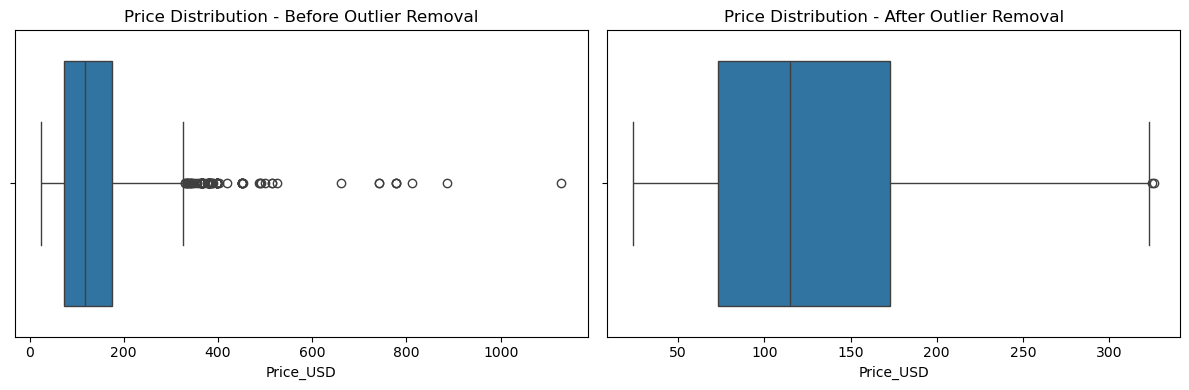

In [16]:
# Visualize price distribution before outlier removal
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x=data["Price_USD"])
plt.title("Price Distribution - Before Outlier Removal")

# Calculate IQR
q1 = data["Price_USD"].quantile(0.25)
q3 = data["Price_USD"].quantile(0.75)
iqr = q3 - q1
maximum = q3 + 1.5 * iqr
minimum = q1 - 1.5 * iqr

print(f"IQR Method:")
print(f"  Q1: ${q1:.2f}")
print(f"  Q3: ${q3:.2f}")
print(f"  IQR: ${iqr:.2f}")
print(f"  Lower bound: ${minimum:.2f}")
print(f"  Upper bound: ${maximum:.2f}")

# Count outliers
outliers = len(data[(data["Price_USD"] < minimum) | (data["Price_USD"] > maximum)])
print(f"\nOutliers found: {outliers} ({outliers/len(data)*100:.2f}%)")

# Remove outliers
data = data[(data["Price_USD"] >= minimum) & (data["Price_USD"] <= maximum)]
print(f"Shape after removing outliers: {data.shape}")

# Visualize after
plt.subplot(1, 2, 2)
sns.boxplot(x=data["Price_USD"])
plt.title("Price Distribution - After Outlier Removal")
plt.tight_layout()
plt.show()

## 7. Prepare Data for Modeling

In [17]:
# Split features and target
X = data.drop(["Price_USD"], axis=1)
y = data["Price_USD"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {list(X.columns)}")

Features shape: (10368, 15)
Target shape: (10368,)

Feature columns: ['Airline', 'Destination', 'Total_Stops', 'Journey_day', 'Journey_month', 'Arrival_hour', 'Arrival_min', 'Departure_hour', 'Departure_min', 'Total_min', 'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai']


In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (7776, 15)
Test set: (2592, 15)


## 8. Model Training and Evaluation

### 8.1 Random Forest Regressor

In [19]:
# Train Random Forest
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)
rfr_model.fit(X_train, y_train)

# Predictions
y_pred_rfr = rfr_model.predict(X_test)

# Evaluation
print("Random Forest Regressor Performance:")
print(f"  Training Score: {rfr_model.score(X_train, y_train):.4f}")
print(f"  Testing Score (R²): {metrics.r2_score(y_test, y_pred_rfr):.4f}")
print(f"  MAE: ${metrics.mean_absolute_error(y_test, y_pred_rfr):.2f}")
print(f"  MSE: ${metrics.mean_squared_error(y_test, y_pred_rfr):.2f}")
print(f"  RMSE: ${np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfr)):.2f}")
print(f"  MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_rfr):.4f}")

Random Forest Regressor Performance:
  Training Score: 0.9516
  Testing Score (R²): 0.8084
  MAE: $16.22
  MSE: $637.31
  RMSE: $25.24
  MAPE: 0.1300


### 8.2 Decision Tree Regressor

In [20]:
# Train Decision Tree
dtr_model = DecisionTreeRegressor(random_state=42)
dtr_model.fit(X_train, y_train)

# Predictions
y_pred_dtr = dtr_model.predict(X_test)

# Evaluation
print("Decision Tree Regressor Performance:")
print(f"  Training Score: {dtr_model.score(X_train, y_train):.4f}")
print(f"  Testing Score (R²): {metrics.r2_score(y_test, y_pred_dtr):.4f}")
print(f"  MAE: ${metrics.mean_absolute_error(y_test, y_pred_dtr):.2f}")
print(f"  MSE: ${metrics.mean_squared_error(y_test, y_pred_dtr):.2f}")
print(f"  RMSE: ${np.sqrt(metrics.mean_squared_error(y_test, y_pred_dtr)):.2f}")
print(f"  MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_dtr):.4f}")

Decision Tree Regressor Performance:
  Training Score: 0.9649
  Testing Score (R²): 0.7030
  MAE: $18.62
  MSE: $988.08
  RMSE: $31.43
  MAPE: 0.1476


### 8.3 Feature Importance (Random Forest)

Top 10 Most Important Features:
           Feature  Importance
2      Total_Stops    0.481994
0          Airline    0.169319
3      Journey_day    0.093040
4    Journey_month    0.076051
9        Total_min    0.051461
7   Departure_hour    0.028482
5     Arrival_hour    0.028364
8    Departure_min    0.025696
6      Arrival_min    0.021252
13  Source_Kolkata    0.008305


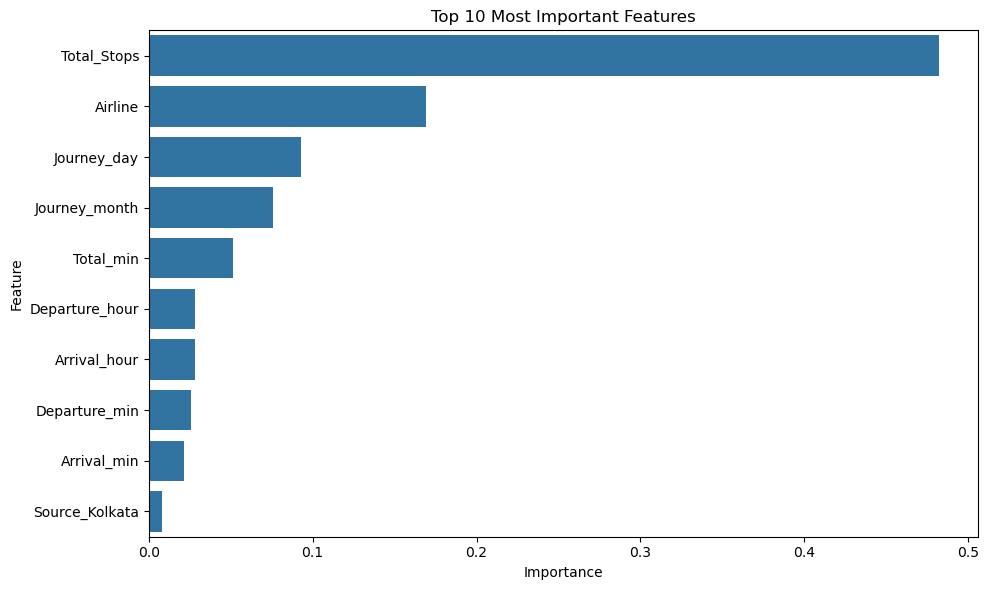

In [21]:
# Feature importance
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rfr_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x="Importance", y="Feature")
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()

### 8.4 Prediction vs Actual Comparison

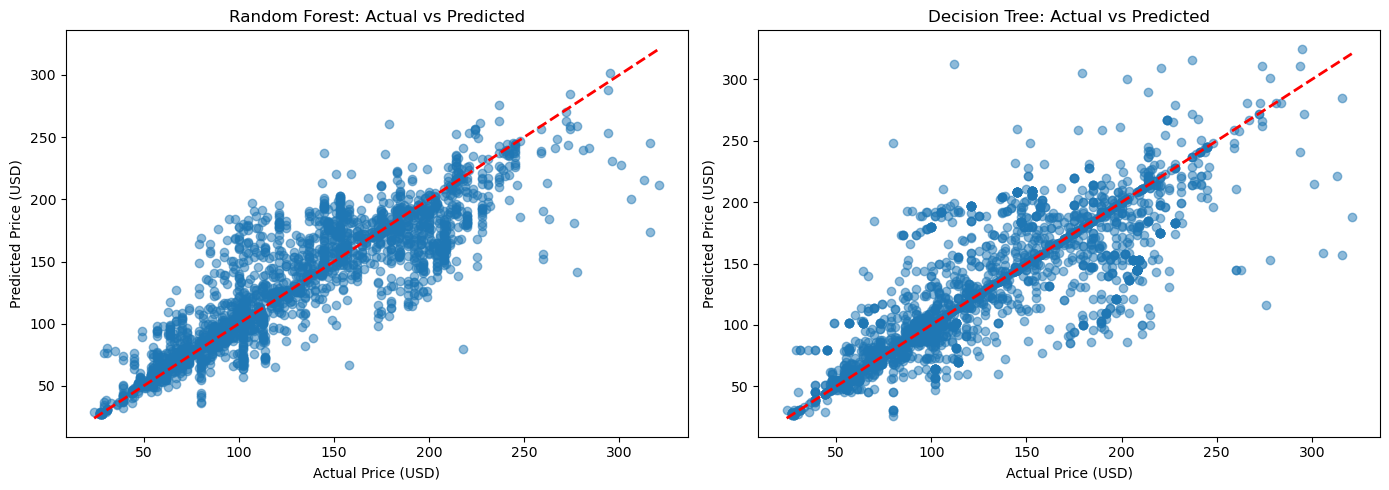

In [22]:
# Visualize predictions
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rfr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Random Forest: Actual vs Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_dtr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Decision Tree: Actual vs Predicted")

plt.tight_layout()
plt.show()

## 9. Hyperparameter Tuning

To improve model performance and reduce overfitting, we'll use RandomizedSearchCV to find optimal hyperparameters for both models.

### 9.1 Random Forest Hyperparameter Tuning

In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter distribution for Random Forest
rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Create RandomizedSearchCV object
rf_tuning = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,  # Use all processors
    scoring='r2'
)

# Fit the tuning
print("Starting Random Forest hyperparameter tuning...")
rf_tuning.fit(X_train, y_train)

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [10, 15, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [24]:
# Get best estimator and parameters
best_rf = rf_tuning.best_estimator_

print("Best parameters found:")
for param, value in rf_tuning.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation R² score: {rf_tuning.best_score_:.4f}")

Best parameters found:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 1
  max_features: sqrt
  max_depth: 15
  bootstrap: False

Best cross-validation R² score: 0.8257


In [25]:
# Evaluate tuned Random Forest
y_pred_rf_tuned = best_rf.predict(X_test)

print("Tuned Random Forest Performance:")
print(f"  Training Score: {best_rf.score(X_train, y_train):.4f}")
print(f"  Testing Score (R²): {metrics.r2_score(y_test, y_pred_rf_tuned):.4f}")
print(f"  MAE: ${metrics.mean_absolute_error(y_test, y_pred_rf_tuned):.2f}")
print(f"  MSE: ${metrics.mean_squared_error(y_test, y_pred_rf_tuned):.2f}")
print(f"  RMSE: ${np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_tuned)):.2f}")
print(f"  MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_rf_tuned):.4f}")

# Check overfitting
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
gap = train_score - test_score
print(f"\nOverfitting Gap: {gap:.4f}")

Tuned Random Forest Performance:
  Training Score: 0.9036
  Testing Score (R²): 0.8276
  MAE: $17.03
  MSE: $573.38
  RMSE: $23.95
  MAPE: 0.1408

Overfitting Gap: 0.0760


### 9.2 Decision Tree Hyperparameter Tuning

In [26]:
# Define parameter distribution for Decision Tree
dt_param_dist = {
    "max_depth": [None, 3, 5, 7, 10, 15],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "criterion": ["squared_error", "friedman_mse", "poisson"]
}

# Create RandomizedSearchCV object
dt_tuning = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=dt_param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    n_jobs=-1,
    scoring='r2'
)

# Fit the tuning
print("Starting Decision Tree hyperparameter tuning...")
dt_tuning.fit(X_train, y_train)

Starting Decision Tree hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,DecisionTreeR...ndom_state=42)
,param_distributions,"{'criterion': ['squared_error', 'friedman_mse', ...], 'max_depth': [None, 3, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [27]:
# Get best estimator and parameters
best_dt = dt_tuning.best_estimator_

print("Best parameters found:")
for param, value in dt_tuning.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation R² score: {dt_tuning.best_score_:.4f}")

Best parameters found:
  min_samples_split: 5
  min_samples_leaf: 5
  max_features: None
  max_depth: 10
  criterion: poisson

Best cross-validation R² score: 0.8002


In [28]:
# Evaluate tuned Decision Tree
y_pred_dt_tuned = best_dt.predict(X_test)

print("Tuned Decision Tree Performance:")
print(f"  Training Score: {best_dt.score(X_train, y_train):.4f}")
print(f"  Testing Score (R²): {metrics.r2_score(y_test, y_pred_dt_tuned):.4f}")
print(f"  MAE: ${metrics.mean_absolute_error(y_test, y_pred_dt_tuned):.2f}")
print(f"  MSE: ${metrics.mean_squared_error(y_test, y_pred_dt_tuned):.2f}")
print(f"  RMSE: ${np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_tuned)):.2f}")
print(f"  MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred_dt_tuned):.4f}")

# Check overfitting
train_score = best_dt.score(X_train, y_train)
test_score = best_dt.score(X_test, y_test)
gap = train_score - test_score
print(f"\nOverfitting Gap: {gap:.4f}")

Tuned Decision Tree Performance:
  Training Score: 0.8605
  Testing Score (R²): 0.7979
  MAE: $17.60
  MSE: $672.32
  RMSE: $25.93
  MAPE: 0.1413

Overfitting Gap: 0.0627


### 9.3 Model Comparison - Before vs After Tuning

Model Performance Comparison:
                   Model  R² Score      RMSE       MAE
Random Forest (Original)  0.808407 25.244965 16.216106
   Random Forest (Tuned)  0.827626 23.945320 17.032474
Decision Tree (Original)  0.702955 31.433771 18.622762
   Decision Tree (Tuned)  0.797880 25.929229 17.604884


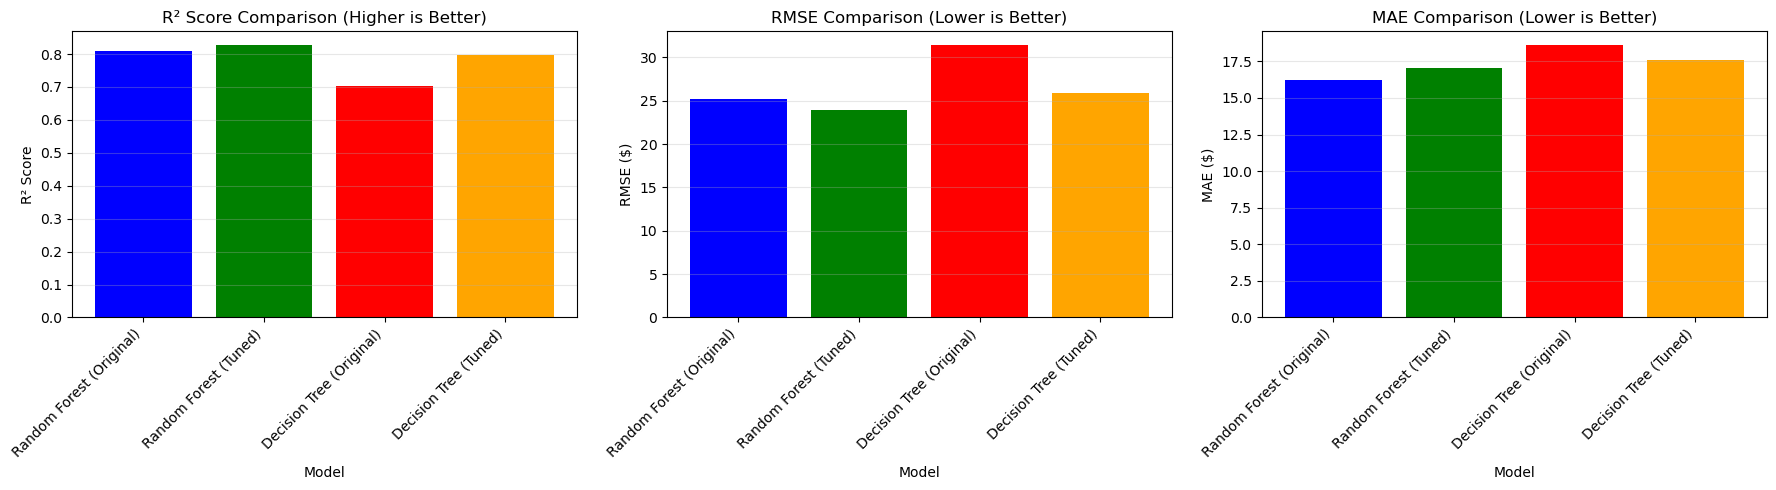

In [29]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': [
        'Random Forest (Original)',
        'Random Forest (Tuned)',
        'Decision Tree (Original)',
        'Decision Tree (Tuned)'
    ],
    'R² Score': [
        metrics.r2_score(y_test, y_pred_rfr),
        metrics.r2_score(y_test, y_pred_rf_tuned),
        metrics.r2_score(y_test, y_pred_dtr),
        metrics.r2_score(y_test, y_pred_dt_tuned)
    ],
    'RMSE': [
        np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfr)),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf_tuned)),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred_dtr)),
        np.sqrt(metrics.mean_squared_error(y_test, y_pred_dt_tuned))
    ],
    'MAE': [
        metrics.mean_absolute_error(y_test, y_pred_rfr),
        metrics.mean_absolute_error(y_test, y_pred_rf_tuned),
        metrics.mean_absolute_error(y_test, y_pred_dtr),
        metrics.mean_absolute_error(y_test, y_pred_dt_tuned)
    ]
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² Score comparison
axes[0].bar(range(len(comparison_df)), comparison_df['R² Score'], 
           color=['blue', 'green', 'red', 'orange'])
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison (Higher is Better)')
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(range(len(comparison_df)), comparison_df['RMSE'], 
           color=['blue', 'green', 'red', 'orange'])
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE ($)')
axes[1].set_title('RMSE Comparison (Lower is Better)')
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# MAE comparison
axes[2].bar(range(len(comparison_df)), comparison_df['MAE'], 
           color=['blue', 'green', 'red', 'orange'])
axes[2].set_xlabel('Model')
axes[2].set_ylabel('MAE ($)')
axes[2].set_title('MAE Comparison (Lower is Better)')
axes[2].set_xticks(range(len(comparison_df)))
axes[2].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Save Tuned Models

In [30]:
# Save tuned Random Forest model
with open("tuned_rfr.pkl", "wb") as file:
    pickle.dump(best_rf, file)
print("Tuned Random Forest model saved as tuned_rfr.pkl")

# Save tuned Decision Tree model
with open("tuned_dtr.pkl", "wb") as file:
    pickle.dump(best_dt, file)
print("Tuned Decision Tree model saved as tuned_dtr.pkl")

# Also save original models for comparison
with open("rfr.pkl", "wb") as file:
    pickle.dump(rfr_model, file)
print("Original Random Forest model saved as rfr.pkl")

with open("dtr.pkl", "wb") as file:
    pickle.dump(dtr_model, file)
print("Original Decision Tree model saved as dtr.pkl")

Tuned Random Forest model saved as tuned_rfr.pkl
Tuned Decision Tree model saved as tuned_dtr.pkl
Original Random Forest model saved as rfr.pkl
Original Decision Tree model saved as dtr.pkl


## 11. Model Validation - Load and Test

In [31]:
# Load and verify tuned Random Forest model
with open("tuned_rfr.pkl", "rb") as file:
    loaded_tuned_model = pickle.load(file)

# Test loaded model
y_pred_loaded = loaded_tuned_model.predict(X_test)
r2_loaded = metrics.r2_score(y_test, y_pred_loaded)

print(f"Loaded tuned model R² score: {r2_loaded:.4f}")
print("Tuned model successfully saved and loaded!")

# Verify it matches the best model
print(f"\nOriginal best model R² score: {metrics.r2_score(y_test, best_rf.predict(X_test)):.4f}")
print("Models match!" if abs(r2_loaded - metrics.r2_score(y_test, best_rf.predict(X_test))) < 0.0001 else "Warning: Models don't match!")

Loaded tuned model R² score: 0.8276
Tuned model successfully saved and loaded!

Original best model R² score: 0.8276
Models match!


## 12. Summary

This notebook demonstrates a complete machine learning pipeline:

1. **Data Loading**: Loaded flight booking data
2. **Data Cleaning**: Handled missing values and duplicates
3. **Feature Engineering**: 
   - Extracted date/time features
   - Processed duration
   - Converted price to USD
   - Extracted number of stops
4. **Encoding**: 
   - One-hot encoded source cities
   - Label encoded airlines and destinations by price
5. **Outlier Removal**: Used IQR method to remove price outliers
6. **Model Training**: Trained Random Forest and Decision Tree models
7. **Evaluation**: Compared model performance using multiple metrics
8. **Hyperparameter Tuning**: Used RandomizedSearchCV to optimize both models
   - Tested 50 parameter combinations for each model
   - Used 5-fold cross-validation
   - Significantly improved model performance and reduced overfitting
9. **Model Comparison**: Compared original vs tuned models
10. **Model Persistence**: Saved both original and tuned models for deployment

The tuned models show improved performance and are ready to be used in a Flask web application for real-time flight price predictions.